# Initial Setup

In [1]:
from datetime import datetime as dt
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import statistics as stats
from matplotlib import pyplot as plt
from hmmlearn import hmm
%matplotlib inline

Using TensorFlow backend.


In [2]:
#set up matplotlib
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (30, 15),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

# constants
MOVING_AVERAGE_WINDOW_SIZE = 30
PREDICTION_WINDOW_SIZE = 50
EPOCH = 100
BATCH_SIZE = 30
LSTM_UNITS = 60
DROPOUT = 0.2
NUM_LSTM_LAYERS = 4

# Utility Functions

In [37]:
def show_graph(data):
    plt.plot(data['DCOILWTICO'])
    plt.xlabel('Date')
    plt.ylabel('Oil Prices')
    plt.title('Trend of Crude Oil Prices')
    plt.show()
     
def get_trend(data):
    return [data[i - 1] < data[i] for i in range(1, len(data))]

def get_moving_averages(data, window_size):
    return [stats.mean(data[i: i + window_size]) for i in range(len(data) - window_size)]

def get_moving_window_dataframes(data, window_size):
    averages, trends = pd.DataFrame(), pd.DataFrame()
    for column in list(data):
        averages[column] = get_moving_averages(data[column], window_size)
        trends[column] = get_trend(averages[column])
    return averages, trends

def split_to_prediction_windows(data, prediction_window):
    x = []
    y = []
    for i in range(prediction_window, len(data)):
        x.append(data[i - prediction_window: i, :])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

def generate_train_test_prediction_windows(train, test, prediction_window_size):
    x_train, y_train = split_to_prediction_windows(train, prediction_window_size)
    x_test, y_test = split_to_prediction_windows(test, prediction_window_size)
    return x_train, y_train, x_test, y_test

def inverse_transform_single_column(scaler, y_values):
    return scaler.inverse_transform(np.array([[y, 0, 0, 0, 0] for y in y_values]))[:, 0]

def train_model(x_train, y_train, units, dropout, num_lstm_layers, model_type):
    model = Sequential(
        [
            LSTM(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])) if model_type == 'lstm' 
            else GRU(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])) if model_type == 'gru' 
            else SimpleRNN(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
            Dropout(dropout)
        ] +
        [
            LSTM(units, return_sequences=True) if model_type == 'lstm' else 
            GRU(units, return_sequences=True) if model_type == 'gru' else
            SimpleRNN(units, return_sequences=True),
            Dropout(dropout)
        ] * (num_lstm_layers - 2) +
        [
            LSTM(units) if model_type == 'lstm' else 
            GRU(units) if model_type == 'gru' else
            SimpleRNN(units),
            Dropout(dropout),
            Dense(1)
        ])
    model.compile(optimizer='rmsprop',loss='mean_squared_error')
    history = model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE)
    return model, history

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
def plot_prediction(scaler, x_test, y_test, models):
    plt.plot(inverse_transform_single_column(scaler, y_test), color='blue',label='Real Price')
    for name, model, color in models:
        y_predict = model.predict(x_test)
        plt.plot(inverse_transform_single_column(scaler, y_predict), color=color,label=name + ' Predicted Price')
    plt.title('Crude Oil Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    
def calculate_mse(x_test, y_test, model):
    y_predict = model.predict(x_test)
    mse = 0
    for i in range(len(y_predict)):
        mse += (y_predict[i] - y_test[i]) ** 2
    return mse / len(y_predict)

# Data Cleaning and Merging of Datasets by Date

In [5]:
oil_prices = pd.read_csv('oil_prices.csv', index_col='DATE', parse_dates=['DATE'], date_parser=lambda date: dt.strptime(date,'%d/%m/%Y').date())
oil_prices = oil_prices[oil_prices['DCOILWTICO'] != '.']
oil_prices['DCOILWTICO'] = pd.to_numeric(oil_prices['DCOILWTICO'])
oil_prices.head()

,DCOILWTICO
DATE,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87


In [6]:
djia = pd.read_csv('djia.csv', index_col='Date', parse_dates=['Date'], date_parser=lambda date: dt.strptime(date,'%d/%m/%Y').date())
djia = djia[(djia['Open'] < 60000) & (djia['Open'] > 0) & (djia['High'] > djia['Low'])]
djia.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


In [7]:
oil_prices = oil_prices.join(djia, how='inner').drop(['Open', 'Adj Close'], axis=1)
oil_prices.head()

,DCOILWTICO,High,Low,Close,Volume
1986-01-02,25.56,1551.949951,1523.739990,1537.729980,10660000
1986-01-03,26.00,1557.109985,1534.979980,1549.199951,10460000
1986-01-06,26.53,1557.000000,1537.040039,1547.589966,11000000
1986-01-07,25.85,1573.739990,1544.500000,1565.709961,15170000
1986-01-08,25.87,1578.099976,1516.630005,1526.609985,20630000


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


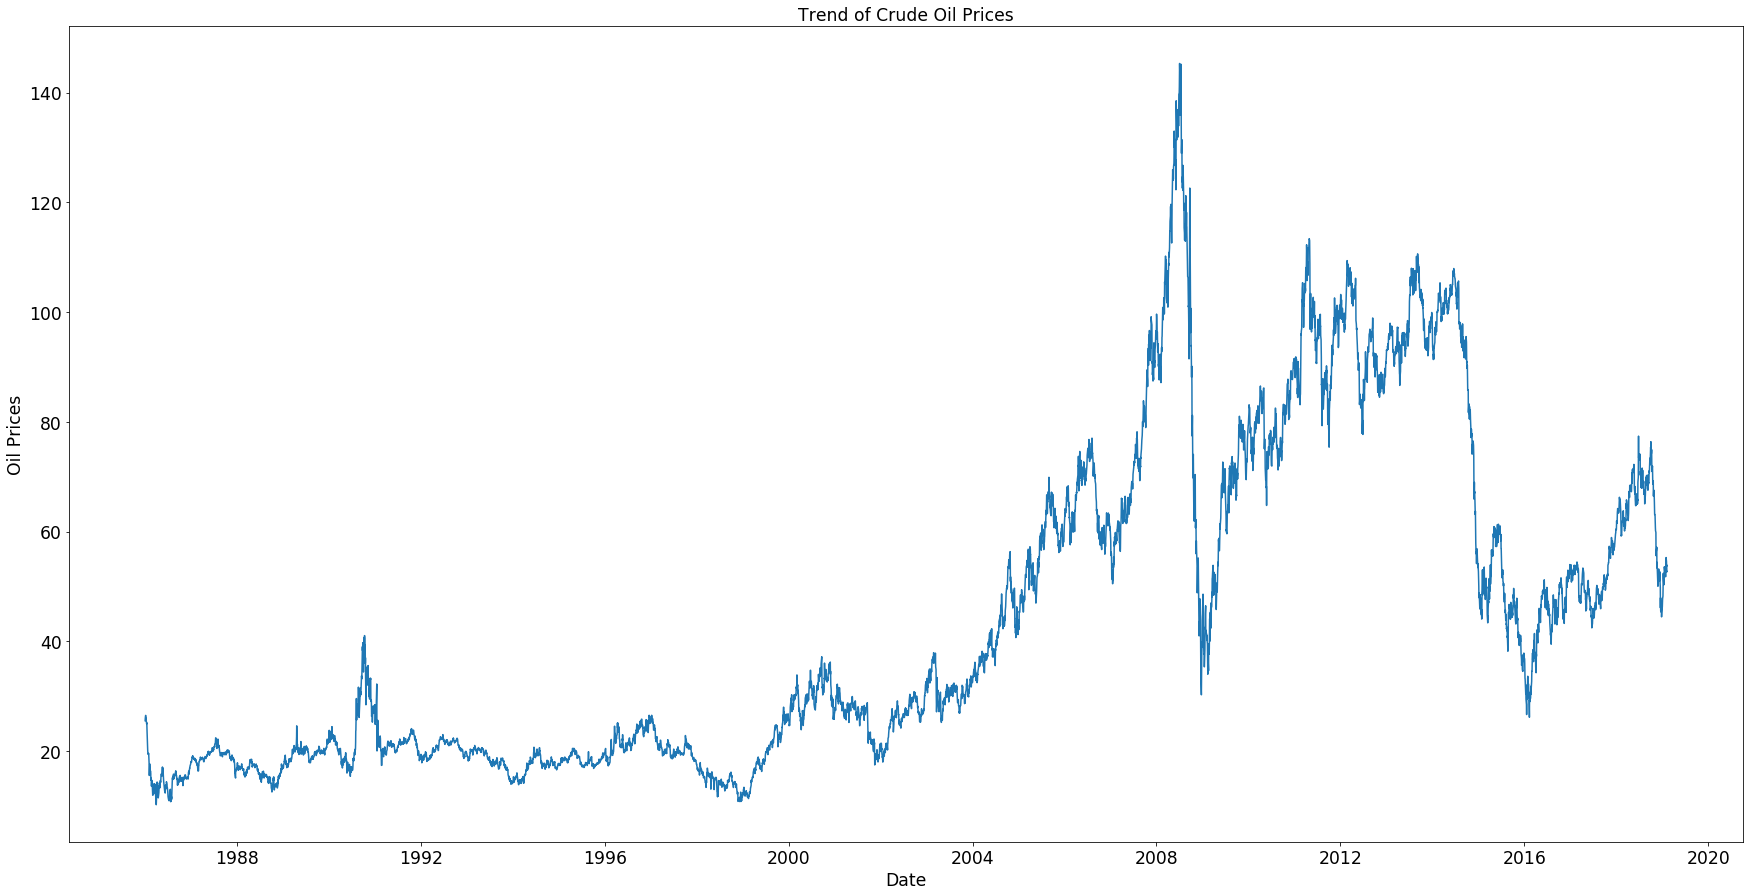

In [8]:
show_graph(oil_prices)

In [9]:
averages, trends = get_moving_window_dataframes(oil_prices, MOVING_AVERAGE_WINDOW_SIZE)

In [10]:
averages.head()

,DCOILWTICO,High,Low,Close,Volume
0,21.076667,1571.169320,1540.901998,1558.276330,1.521833e+07
1,20.759000,1575.060653,1544.647998,1562.500329,1.549967e+07
2,20.382333,1579.341988,1548.463000,1566.819665,1.571533e+07
3,20.000667,1583.749321,1552.262667,1570.508667,1.585467e+07
4,19.610000,1587.139986,1555.511666,1574.079000,1.581267e+07


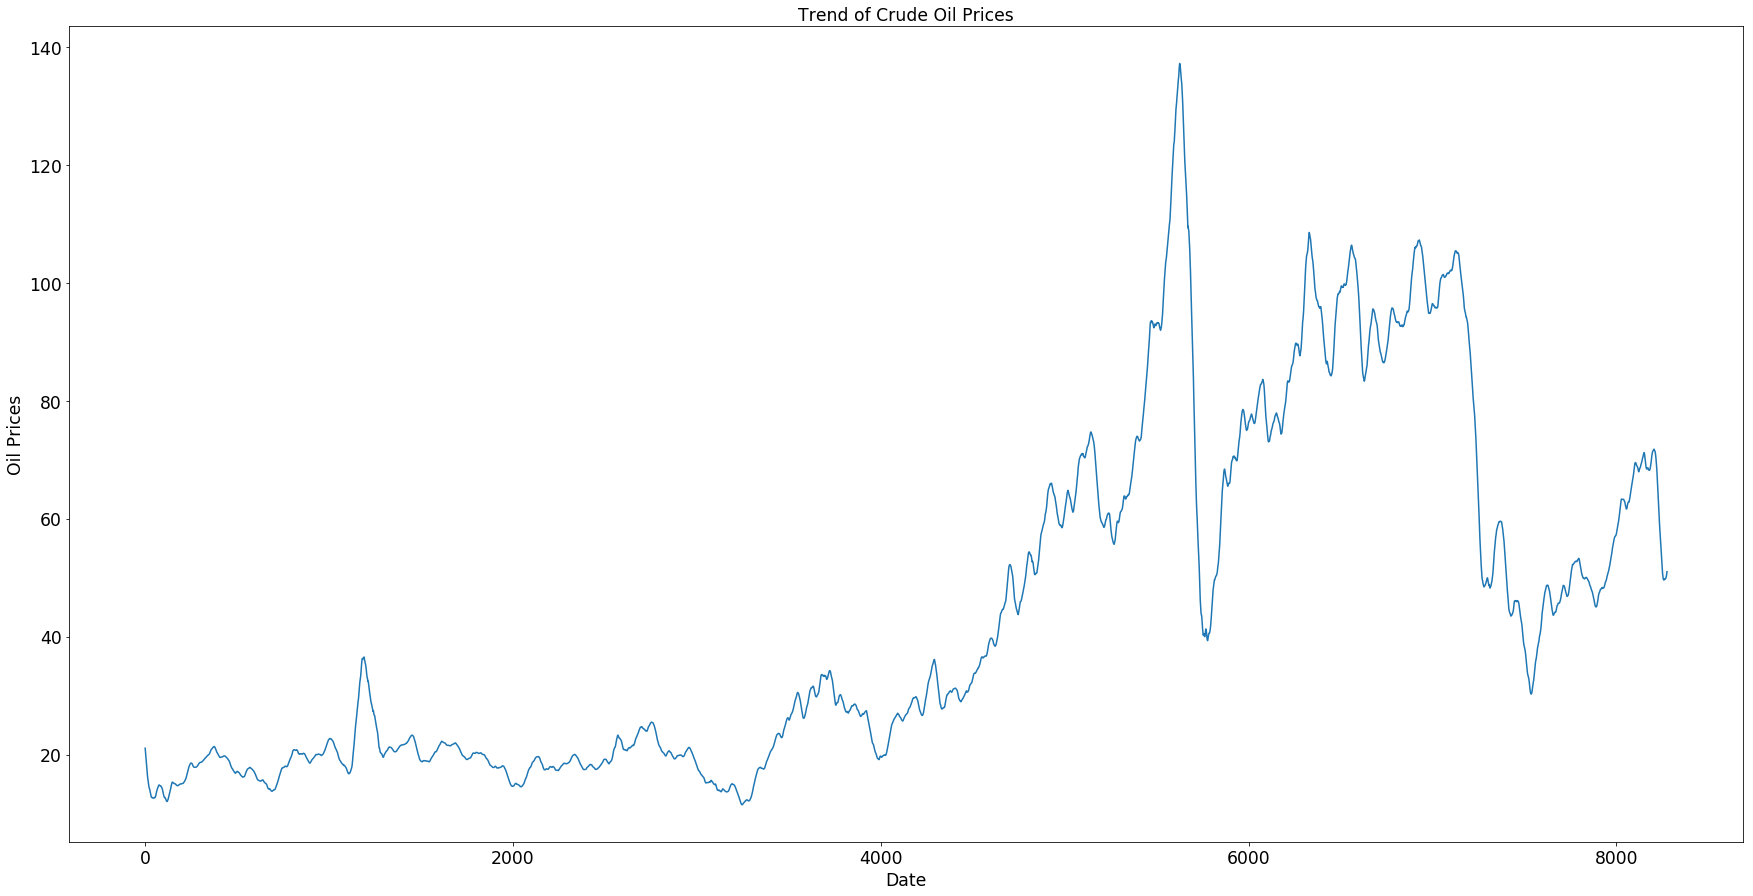

In [11]:
show_graph(averages)

# Hidden Markov Model

In [12]:
recent_trends = trends[-3000:]['DCOILWTICO'].values.astype(int).reshape(-1, 1)
remodel = hmm.MultinomialHMM(n_components=5, n_iter=200)
remodel.fit(recent_trends[:2000])
test_set = recent_trends[2000:]
predictions = remodel.predict(test_set)
accuracy = (predictions == test_set.flatten()).sum() * 100 / len(predictions)
'Accuracy for Hidden Markov Model is {}%.'.format(accuracy)

'Accuracy for Hidden Markov Model is 50.5%.'

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
matrix = scaler.fit_transform(averages[-3000:])
matrix_train = matrix[:2000]
matrix_test = matrix[2000:]
x_train, y_train, x_test, y_test = generate_train_test_prediction_windows(matrix_train, matrix_test, PREDICTION_WINDOW_SIZE)

# RNN Model

In [29]:
rnn_model, rnn_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'rnn')

Epoch 1/100
1950/1950 [==============================] - 3s 2ms/step - loss: 0.2970
Epoch 2/100
1950/1950 [==============================] - 2s 944us/step - loss: 0.1671
Epoch 3/100
1950/1950 [==============================] - 2s 917us/step - loss: 0.1017
Epoch 4/100
1950/1950 [==============================] - 2s 951us/step - loss: 0.0732
Epoch 5/100
1950/1950 [==============================] - 2s 894us/step - loss: 0.0511
Epoch 6/100
1950/1950 [==============================] - 2s 912us/step - loss: 0.0372
Epoch 7/100
1950/1950 [==============================] - 2s 822us/step - loss: 0.0256
Epoch 8/100
1950/1950 [==============================] - 2s 882us/step - loss: 0.0204
Epoch 9/100
1950/1950 [==============================] - 2s 826us/step - loss: 0.0153
Epoch 10/100
1950/1950 [==============================] - 2s 894us/step - loss: 0.0124
Epoch 11/100
1950/1950 [==============================] - 2s 863us/step - loss: 0.0098
Epoch 12/100
1950/1950 [==============================

1950/1950 [==============================] - 2s 1ms/step - loss: 7.6067e-04
Epoch 95/100
1950/1950 [==============================] - 2s 1ms/step - loss: 7.9057e-04
Epoch 96/100
1950/1950 [==============================] - 2s 968us/step - loss: 7.4961e-04
Epoch 97/100
1950/1950 [==============================] - 2s 880us/step - loss: 7.1239e-04
Epoch 98/100
1950/1950 [==============================] - 2s 940us/step - loss: 8.2304e-04
Epoch 99/100
1950/1950 [==============================] - 2s 938us/step - loss: 7.1092e-04
Epoch 100/100
1950/1950 [==============================] - 2s 929us/step - loss: 7.0503e-04


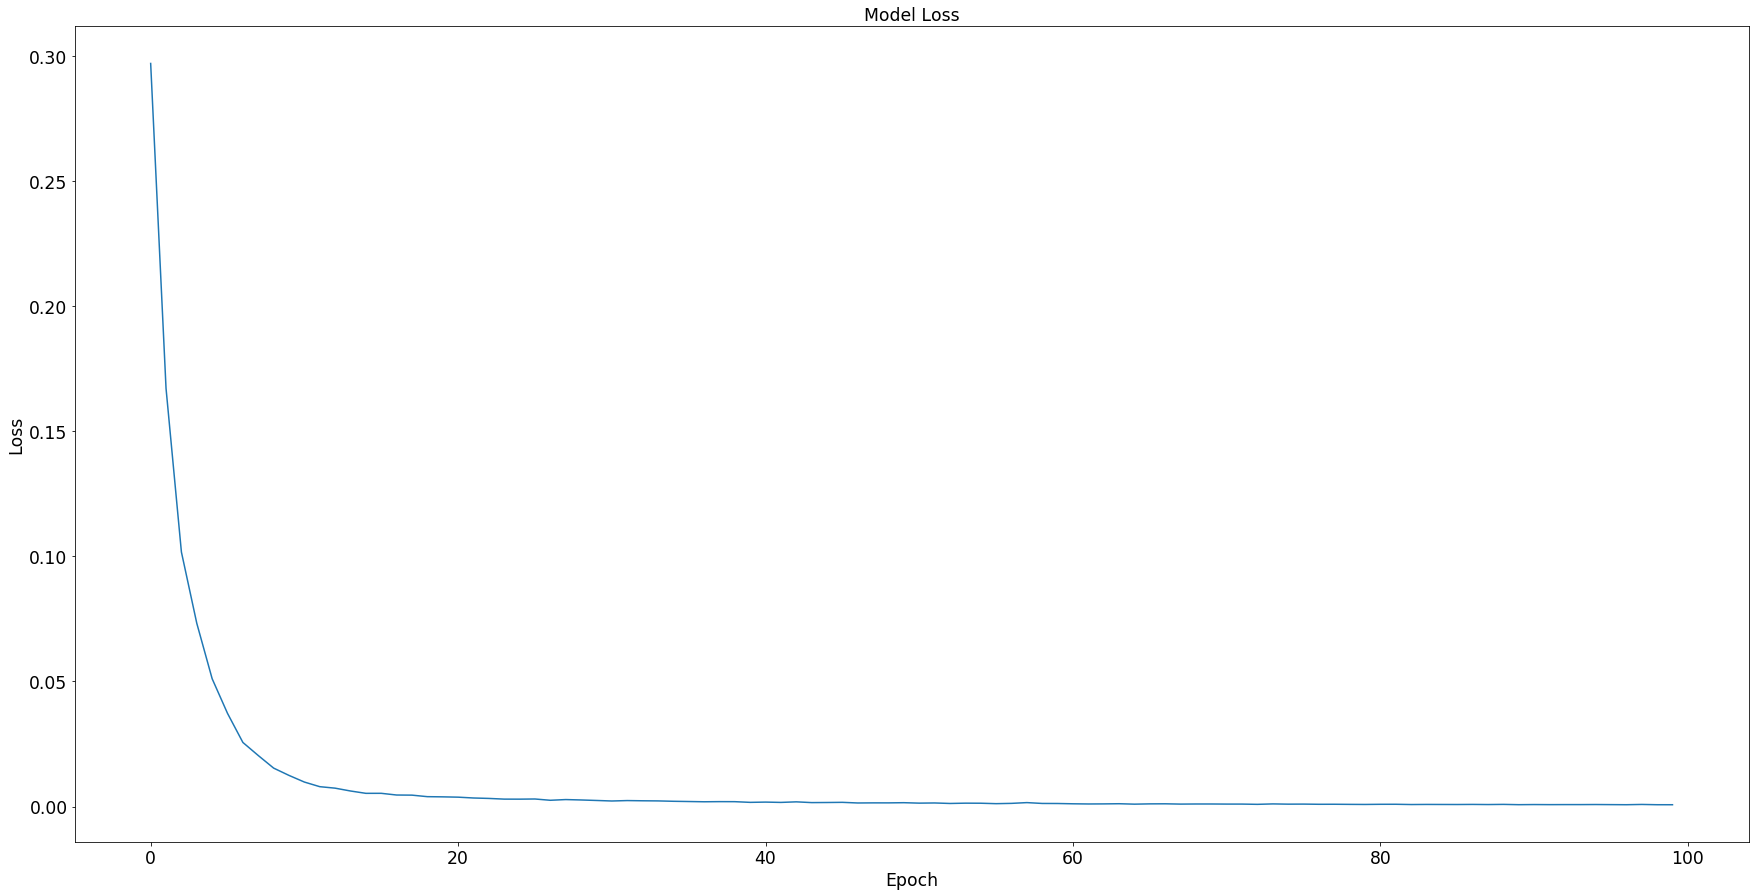

In [30]:
plot_loss(rnn_history)

# LSTM Model

In [31]:
lstm_model, lstm_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'lstm')

Epoch 1/100
1950/1950 [==============================] - 9s 5ms/step - loss: 0.0240
Epoch 2/100
1950/1950 [==============================] - 6s 3ms/step - loss: 0.0110
Epoch 3/100
1950/1950 [==============================] - 6s 3ms/step - loss: 0.0085
Epoch 4/100
1950/1950 [==============================] - 6s 3ms/step - loss: 0.0073
Epoch 5/100
1950/1950 [==============================] - 6s 3ms/step - loss: 0.0064
Epoch 6/100
1950/1950 [==============================] - 6s 3ms/step - loss: 0.0055
Epoch 7/100
1950/1950 [==============================] - 6s 3ms/step - loss: 0.0048
Epoch 8/100
1950/1950 [==============================] - 6s 3ms/step - loss: 0.0045
Epoch 9/100
1950/1950 [==============================] - 6s 3ms/step - loss: 0.0039
Epoch 10/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0038
Epoch 11/100
1950/1950 [==============================] - 6s 3ms/step - loss: 0.0036
Epoch 12/100
1950/1950 [==============================] - 6s 3ms/step - lo

1950/1950 [==============================] - 6s 3ms/step - loss: 5.4109e-04
Epoch 96/100
1950/1950 [==============================] - 6s 3ms/step - loss: 5.5532e-04
Epoch 97/100
1950/1950 [==============================] - 6s 3ms/step - loss: 4.9762e-04
Epoch 98/100
1950/1950 [==============================] - 6s 3ms/step - loss: 4.9626e-04
Epoch 99/100
1950/1950 [==============================] - 6s 3ms/step - loss: 5.3932e-04
Epoch 100/100
1950/1950 [==============================] - 6s 3ms/step - loss: 5.1915e-04


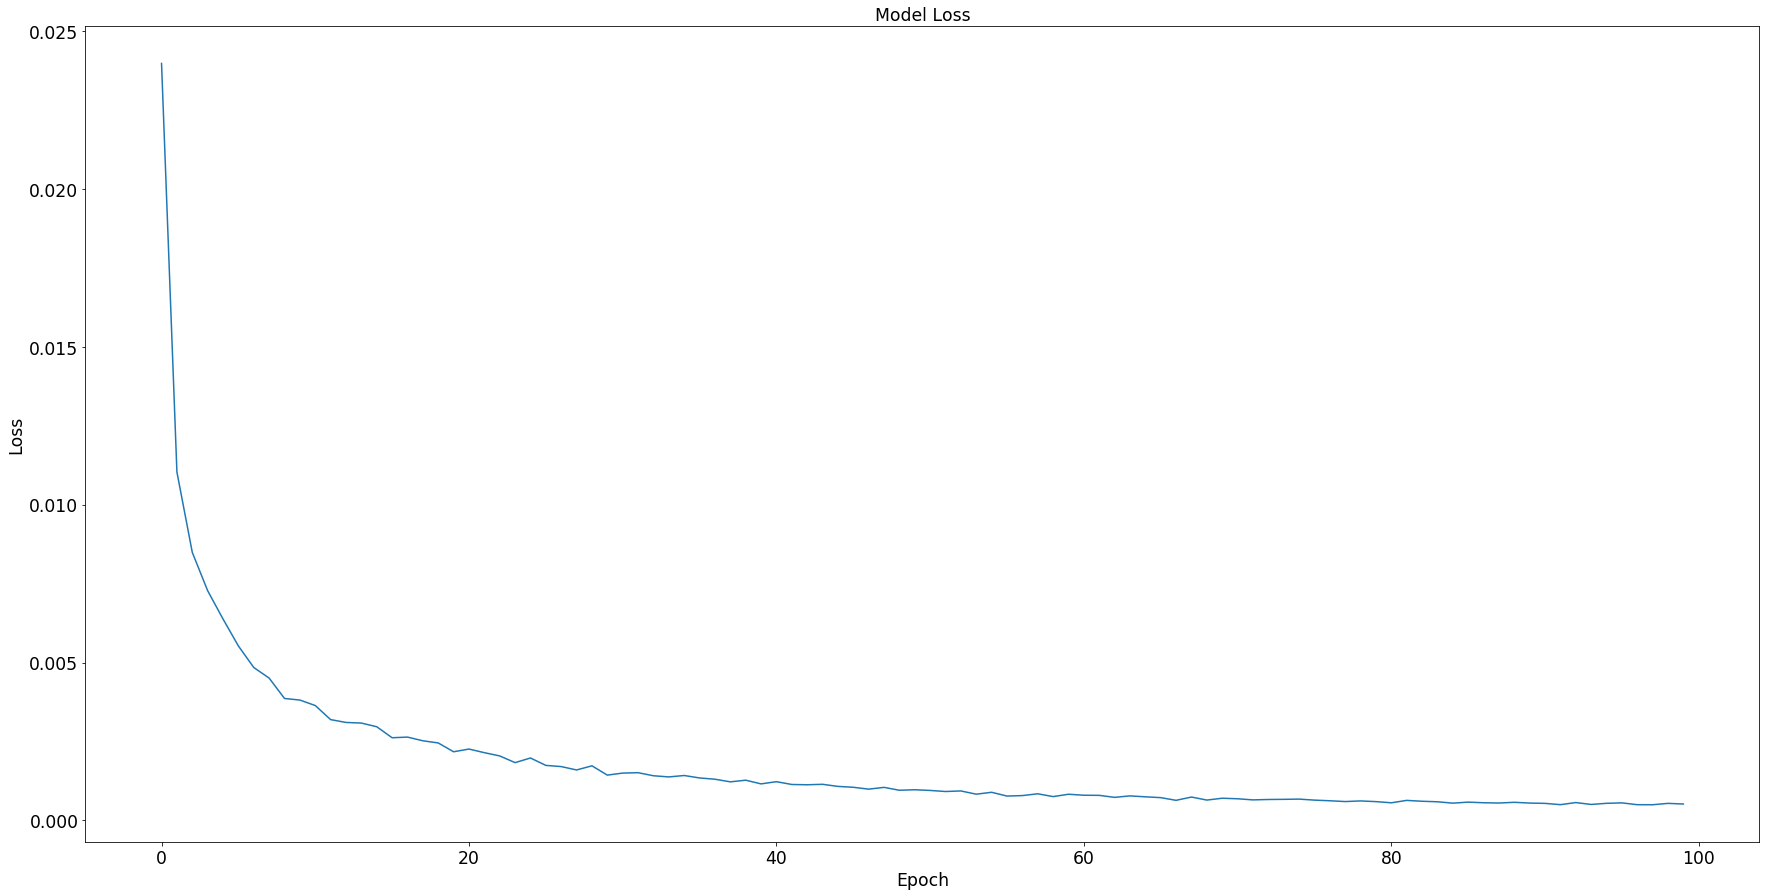

In [32]:
plot_loss(lstm_history)

# GRU Model

In [33]:
gru_model, gru_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'gru')

Epoch 1/100
1950/1950 [==============================] - 8s 4ms/step - loss: 0.0196
Epoch 2/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0095
Epoch 3/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0075
Epoch 4/100
1950/1950 [==============================] - 5s 2ms/step - loss: 0.0064
Epoch 5/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0059
Epoch 6/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0049
Epoch 7/100
1950/1950 [==============================] - 5s 2ms/step - loss: 0.0046
Epoch 8/100
1950/1950 [==============================] - 5s 2ms/step - loss: 0.0046
Epoch 9/100
1950/1950 [==============================] - 5s 2ms/step - loss: 0.0041
Epoch 10/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0037
Epoch 11/100
1950/1950 [==============================] - 5s 2ms/step - loss: 0.0037
Epoch 12/100
1950/1950 [==============================] - 5s 3ms/step - lo

1950/1950 [==============================] - 5s 2ms/step - loss: 4.8503e-04
Epoch 96/100
1950/1950 [==============================] - 5s 2ms/step - loss: 4.4280e-04
Epoch 97/100
1950/1950 [==============================] - 5s 2ms/step - loss: 4.7373e-04
Epoch 98/100
1950/1950 [==============================] - 5s 2ms/step - loss: 4.6519e-04
Epoch 99/100
1950/1950 [==============================] - 5s 2ms/step - loss: 4.6131e-04
Epoch 100/100
1950/1950 [==============================] - 5s 2ms/step - loss: 4.5996e-04


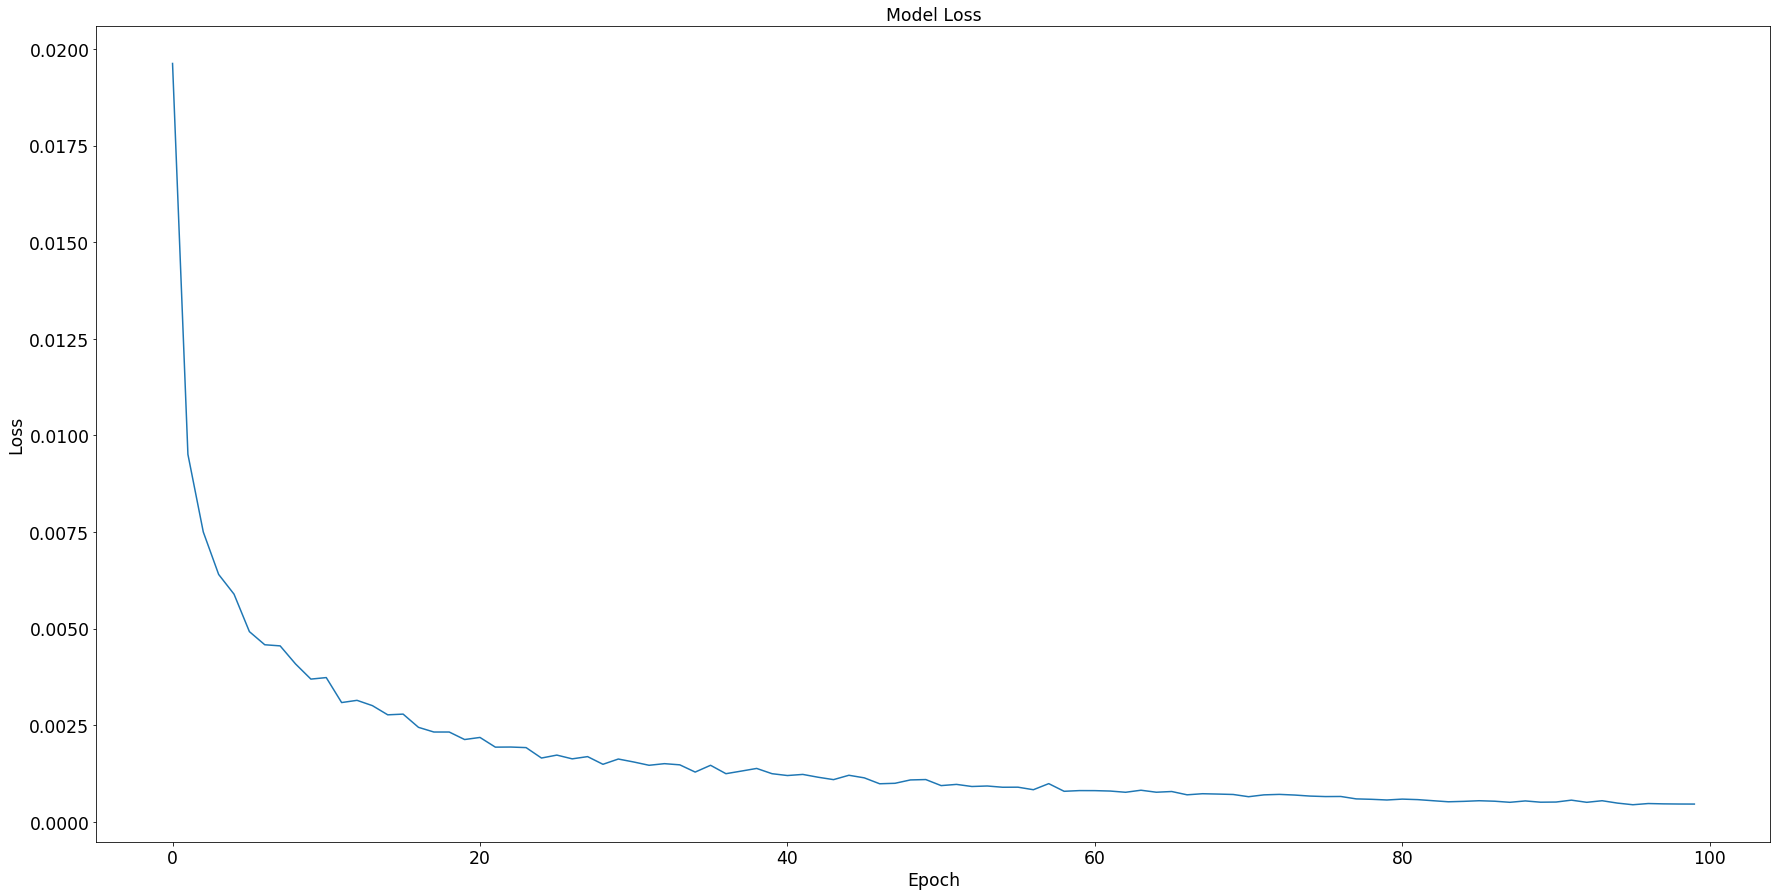

In [34]:
plot_loss(gru_history)

# Results

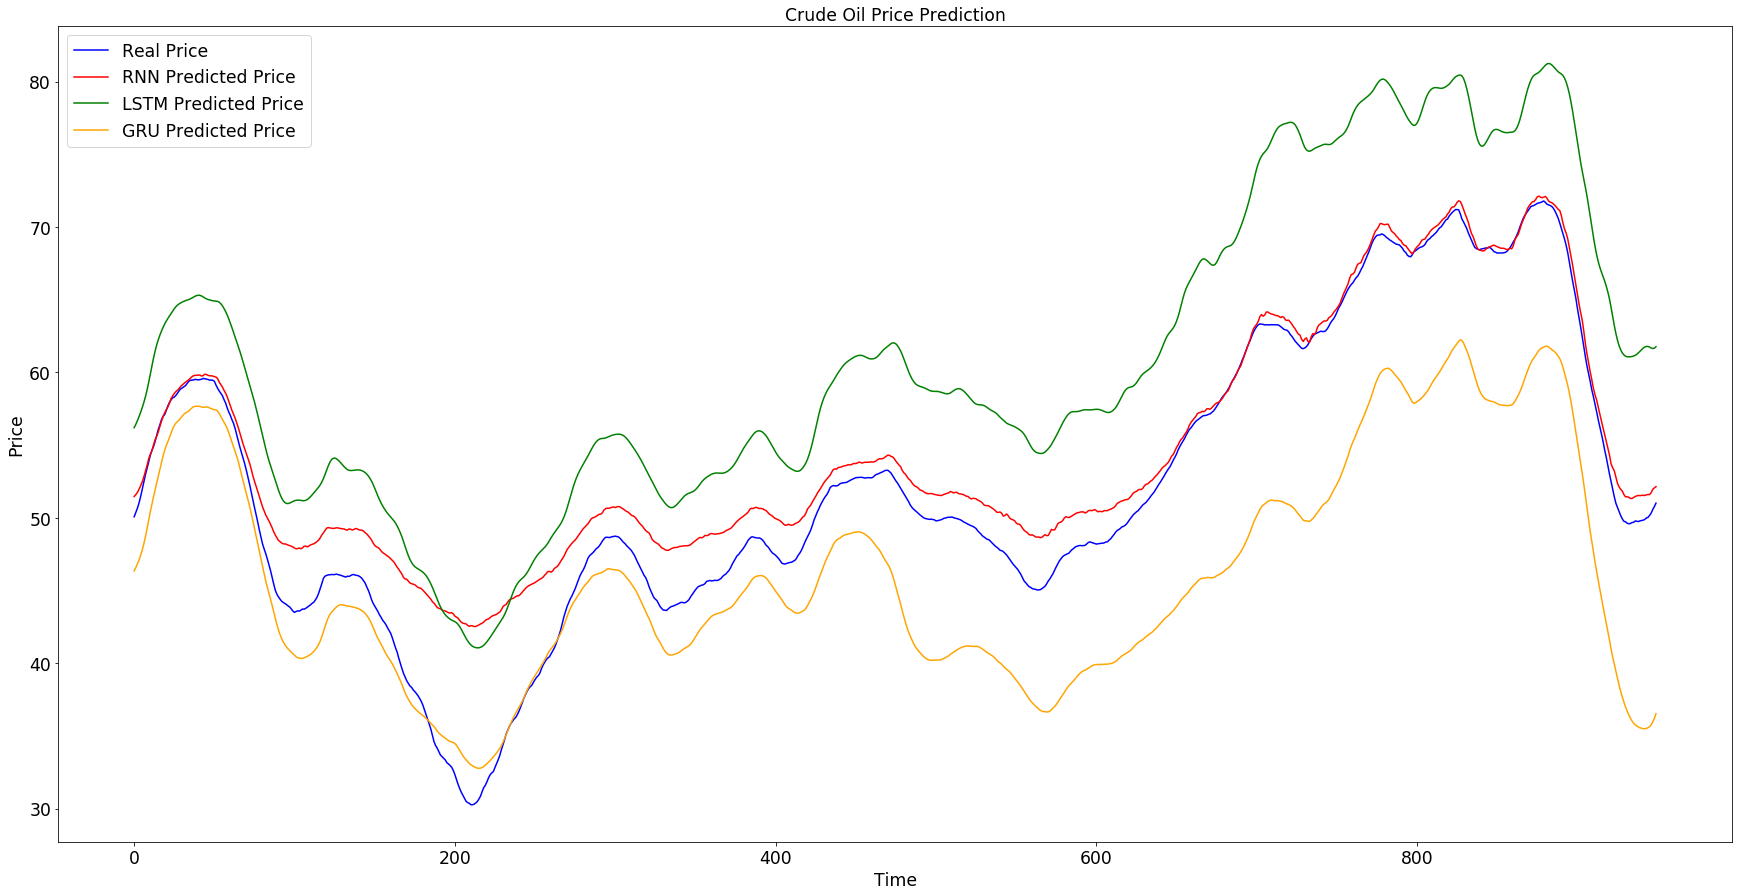

In [35]:
plot_prediction(scaler, x_test, y_test, [('RNN', rnn_model, 'red'), ('LSTM', lstm_model, 'green'), ('GRU', gru_model, 'orange')])

In [38]:
rnn_mse = calculate_mse(x_test, y_test, rnn_model)
print('Mean Square Error for RNN is {}.'.format(rnn_mse))
lstm_mse = calculate_mse(x_test, y_test, lstm_model)
print('Mean Square Error for LSTM is {}.'.format(lstm_mse))
gru_mse = calculate_mse(x_test, y_test, gru_model)
print('Mean Square Error for GRU is {}.'.format(gru_mse))

Mean Square Error for RNN is [0.00111717].
Mean Square Error for LSTM is [0.00704157].
Mean Square Error for GRU is [0.00497331].
